In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import nltk, re, collections, pickle, os # nltk - Natural Language Toolkit
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

plt.rcParams['figure.figsize'] = (15, 5)
plt.style.use('ggplot')
seed = 42

import warnings
warnings.filterwarnings(action = "ignore")
warnings.simplefilter(action = 'ignore', category = Warning)

In [ ]:
pd.options.display.float_format = '{:.3f}'.format

In [ ]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'accuracy' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'accuracy' in s and 'val' in s]

    plt.figure(figsize = (12, 5), dpi = 100)
    COLOR = 'gray'

    plt.rc('legend', fontsize = 14)   # legend fontsize
    plt.rc('figure', titlesize = 12)  # fontsize of the figure title

    if len(loss_list) == 0:
        print('Loss is missing in history')
        return

    ## As loss always exists
    epochs = range(1, len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.subplot(1, 2, 1)
    plt.subplots_adjust(wspace = 2, hspace = 2)
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.titlecolor'] = 'black'
    plt.rcParams['axes.labelcolor'] = COLOR
    plt.rcParams['xtick.color'] = COLOR
    plt.rcParams['ytick.color'] = COLOR
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b-o',
                 label = 'Train (' + str(str(format(history.history[l][-1],'.4f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g',
                 label = 'Valid (' + str(str(format(history.history[l][-1],'.4f'))+')'))

    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend(facecolor = 'gray', loc = 'best')
    plt.grid(True)
    plt.tight_layout()

    ## Accuracy
    plt.subplot(1, 2, 2)
    plt.subplots_adjust(wspace = 2, hspace = 2)
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.titlecolor'] = 'black'
    plt.rcParams['axes.labelcolor'] = COLOR
    plt.rcParams['xtick.color'] = COLOR
    plt.rcParams['ytick.color'] = COLOR
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b-o',
                 label = 'Train (' + str(format(history.history[l][-1],'.4f'))+')')
    for l in val_acc_list:
        plt.plot(epochs, history.history[l], 'g',
                 label = 'Valid (' + str(format(history.history[l][-1],'.4f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(facecolor = 'gray', loc = 'best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_conf_matr(conf_matr, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.winter):
  """
  Citation
  ---------
  http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

  """
  import itertools

  accuracy = np.trace(conf_matr) / np.sum(conf_matr).astype('float')
  sns.set(font_scale = 1.4)

  plt.figure(figsize = (12, 8))
  plt.imshow(conf_matr, interpolation = 'nearest', cmap = cmap)
  title = '\n' + title + '\n'
  plt.title(title)
  plt.colorbar()

  if classes is not None:
      tick_marks = np.arange(len(classes))
      plt.xticks(tick_marks, classes, rotation = 45)
      plt.yticks(tick_marks, classes)

  if normalize:
      conf_matr = conf_matr.astype('float') / conf_matr.sum(axis = 1)[:, np.newaxis]


  thresh = conf_matr.max() / 1.5 if normalize else conf_matr.max() / 2
  for i, j in itertools.product(range(conf_matr.shape[0]), range(conf_matr.shape[1])):
      if normalize:
          plt.text(j, i, "{:0.2f}%".format(conf_matr[i, j] * 100),
                    horizontalalignment = "center",
                    fontweight = 'bold',
                    color = "white" if conf_matr[i, j] > thresh else "black")
      else:
          plt.text(j, i, "{:,}".format(conf_matr[i, j]),
                    horizontalalignment = "center",
                    fontweight = 'bold',
                    color = "white" if conf_matr[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label\n\nAccuracy = {:0.2f}%; Error = {:0.2f}%'.format(accuracy * 100, (1 - accuracy) * 100))
  plt.show()


def plot_words(set, number):
  words_counter = collections.Counter([word for sentence in set for word in sentence.split()]) # finding words along with count
  most_counted = words_counter.most_common(number)
  most_count = pd.DataFrame(most_counted, columns = ["Words", "Amount"]).sort_values(by = "Amount") # sorted data frame
  most_count.plot.barh(x = "Words",
                       y = "Amount",
                       color = "blue",
                       figsize = (10, 15))
  for i, v in enumerate(most_count["Amount"]):
    plt.text(v, i,
             " " + str(v),
             color = 'black',
             va = 'center',
             fontweight = 'bold')

def word_cloud(tag):
  df_words_nl = ' '.join(list(df_spam[df_spam['feature'] == tag]['message']))
  df_wc_nl = WordCloud(width = 600, height = 512).generate(df_words_nl)
  plt.figure(figsize = (13, 9), facecolor = 'k')
  plt.imshow(df_wc_nl)
  plt.axis('off')
  plt.tight_layout(pad = 1)
  plt.show()

In [ ]:
df_spam = pd.read_csv('spam.csv', encoding = 'latin-1')

In [ ]:
df_spam = df_spam.filter(['v1', 'v2'], axis = 1)
df_spam.columns = ['feature', 'message']
df_spam.drop_duplicates(inplace = True, ignore_index = True)
print('Number of null values:\n')
df_spam.isnull().sum()

Number of null values:



,0
feature,0
message,0


In [ ]:
df_spam['feature'].value_counts()

,count
feature,
ham,4516
spam,653


In [ ]:
df_spam.shape, df_spam.columns

((5169, 2), Index(['feature', 'message'], dtype='object'))

In [ ]:
df_spam.describe().T

,count,unique,top,freq
feature,5169,2,ham,4516
message,5169,5169,Rofl. Its true to its name,1


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

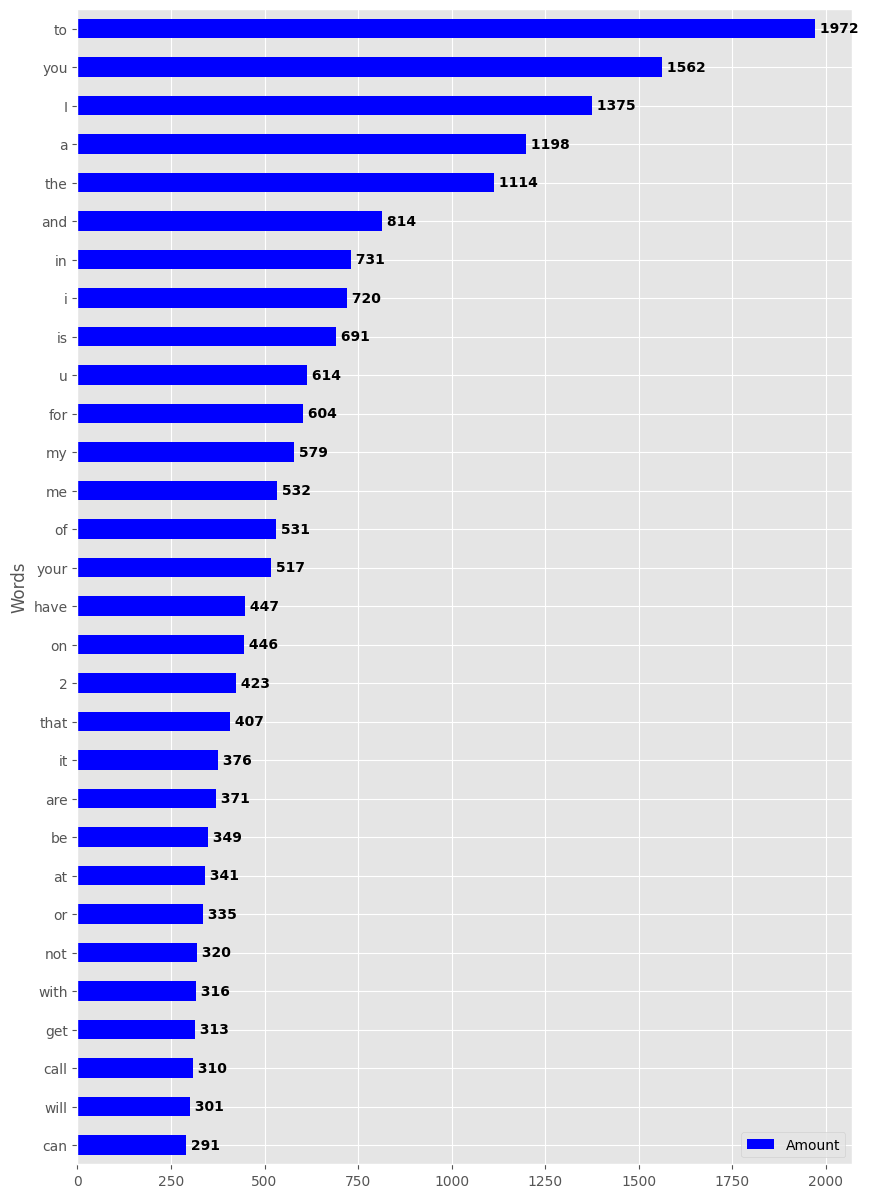

In [ ]:
plot_words(df_spam['message'], number = 30)

In [ ]:
size_vocabulary = 1000
embedding_dimension = 64
trunc_type = 'post'
padding_type = 'post'
threshold = 0.5
oov_token = "<OOV>"
test_size, valid_size = 0.05, 0.2
num_epochs = 20
drop_level = 0.3

In [ ]:
print("\t\tStage I. Preliminary actions. Preparing of needed sets\n")
full_df_l = []
lemmatizer = WordNetLemmatizer()
for i in range(df_spam.shape[0]):
    mess_1 = df_spam.iloc[i, 1]
    mess_1 = re.sub('\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr', mess_1)
    mess_1 = re.sub('(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr', mess_1)
    mess_1 = re.sub('£|\$', 'moneysymb', mess_1)
    mess_1 = re.sub('\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b', 'phonenumbr', mess_1)
    mess_1 = re.sub('\d+(\.\d+)?', 'numbr', mess_1)
    mess_1 = re.sub('[^\w\d\s]', ' ', mess_1)
    mess_1 = re.sub('[^A-Za-z]', ' ', mess_1).lower()
    token_messages = word_tokenize(mess_1)
    mess = []
    for word in token_messages:
        if word not in set(stopwords.words('english')):
            mess.append(lemmatizer.lemmatize(word))
    txt_mess = " ".join(mess)
    full_df_l.append(txt_mess)

		Stage I. Preliminary actions. Preparing of needed sets



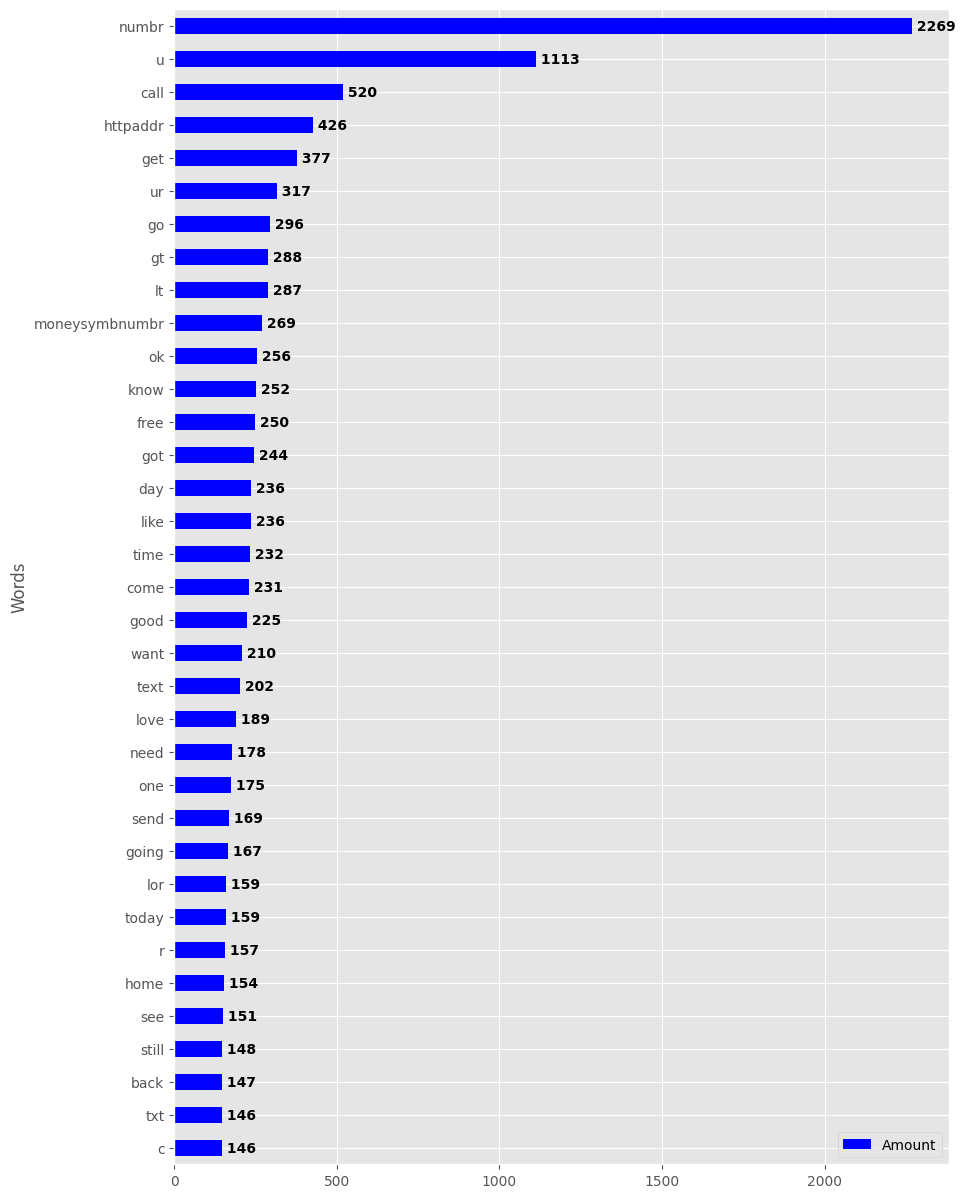

In [ ]:
plot_words(full_df_l, number = 35)

In [ ]:
add_df = CountVectorizer(max_features = size_vocabulary)
X = add_df.fit_transform(full_df_l).toarray()
y = df_spam.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = (test_size + valid_size), random_state = seed)
print('Number of rows in test set: ' + str(X_test.shape))
print('Number of rows in training set: ' + str(X_train.shape))

Number of rows in test set: (1293, 1000)
Number of rows in training set: (3876, 1000)


		Stage IIa. Guassian Naive Bayes

The first two predicted labels: spam ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.99      0.77      0.87      1107
        spam       0.41      0.94      0.57       186

    accuracy                           0.79      1293
   macro avg       0.70      0.85      0.72      1293
weighted avg       0.90      0.79      0.82      1293
 



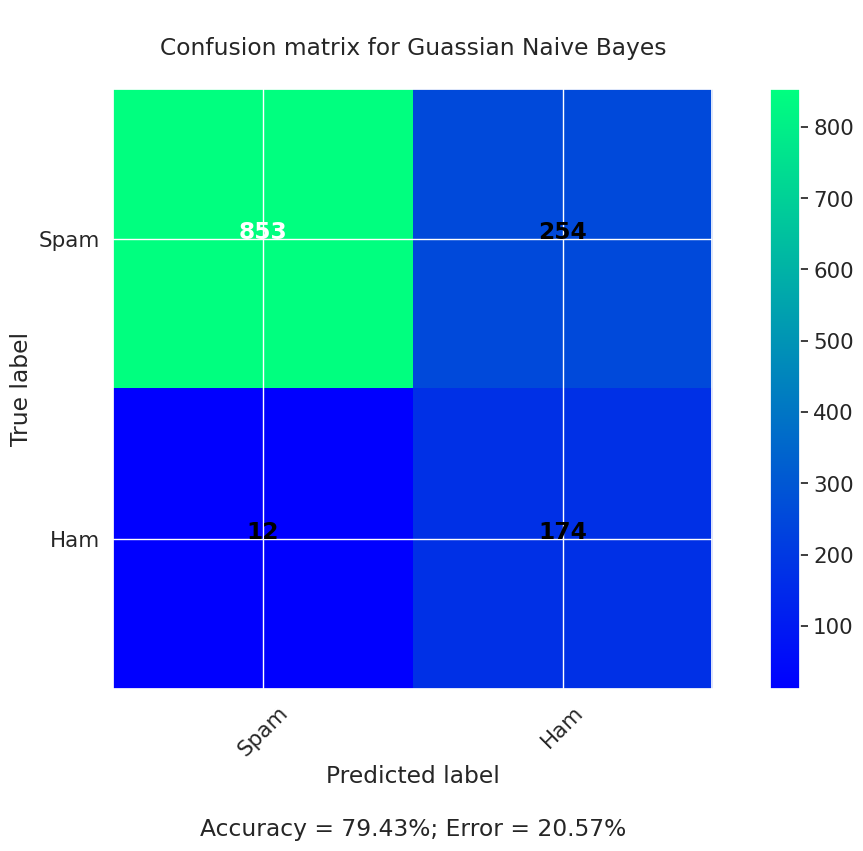

In [ ]:
print("\t\tStage IIa. Guassian Naive Bayes\n")
class_NBC = GaussianNB().fit(X_train, y_train) # Guassian Naive Bayes
y_pred_NBC = class_NBC.predict(X_test)
print('The first two predicted labels:', y_pred_NBC[0],y_pred_NBC[1], '\n')
conf_m_NBC = confusion_matrix(y_test, y_pred_NBC)
class_rep_NBC = classification_report(y_test, y_pred_NBC)
print('\t\t\tClassification report:\n\n', class_rep_NBC, '\n')
plot_conf_matr(conf_m_NBC, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for Guassian Naive Bayes')

		Stage IIb. Multinomial Naive Bayes

The first two predicted labels: ham ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.99      0.98      0.98      1107
        spam       0.90      0.92      0.91       186

    accuracy                           0.97      1293
   macro avg       0.94      0.95      0.95      1293
weighted avg       0.97      0.97      0.97      1293
 



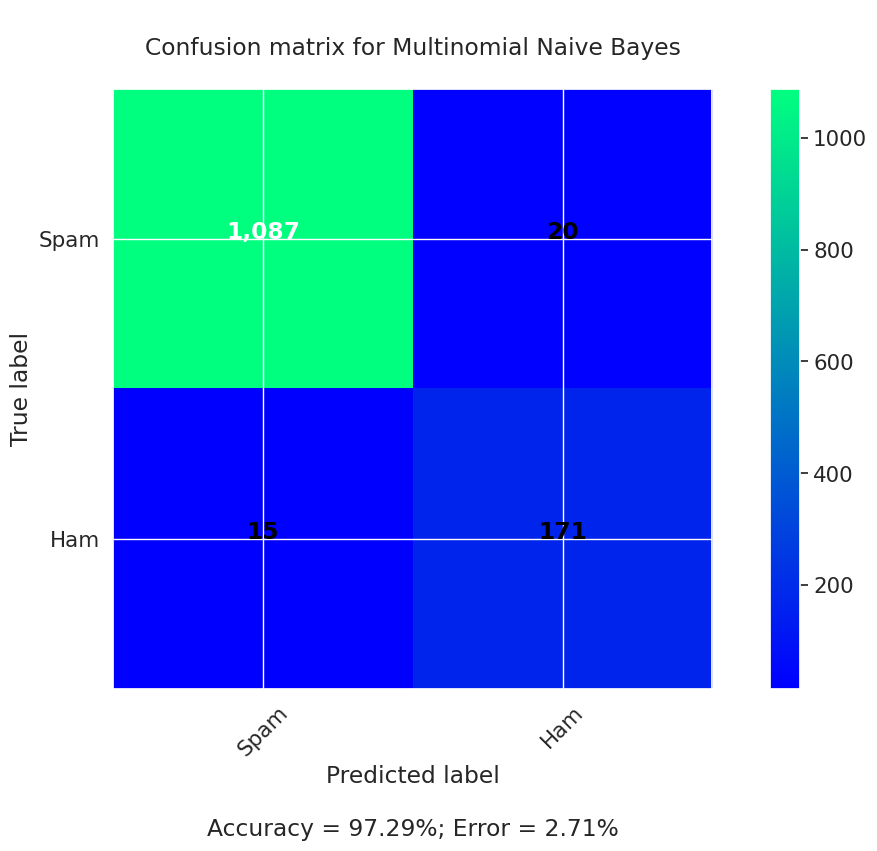

In [ ]:
print("\t\tStage IIb. Multinomial Naive Bayes\n")
class_MNB = MultinomialNB().fit(X_train, y_train) # Multinomial Naive Bayes
y_pred_MNB = class_MNB.predict(X_test)
print('The first two predicted labels:', y_pred_MNB[0],y_pred_MNB[1], '\n')
conf_m_MNB = confusion_matrix(y_test, y_pred_MNB)
class_rep_MNB = classification_report(y_test, y_pred_MNB)
print('\t\t\tClassification report:\n\n', class_rep_MNB, '\n')
plot_conf_matr(conf_m_MNB, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for Multinomial Naive Bayes')

		Stage IV. Logistic Regression

The first two predicted labels: ham ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1107
        spam       0.98      0.86      0.91       186

    accuracy                           0.98      1293
   macro avg       0.98      0.93      0.95      1293
weighted avg       0.98      0.98      0.98      1293
 



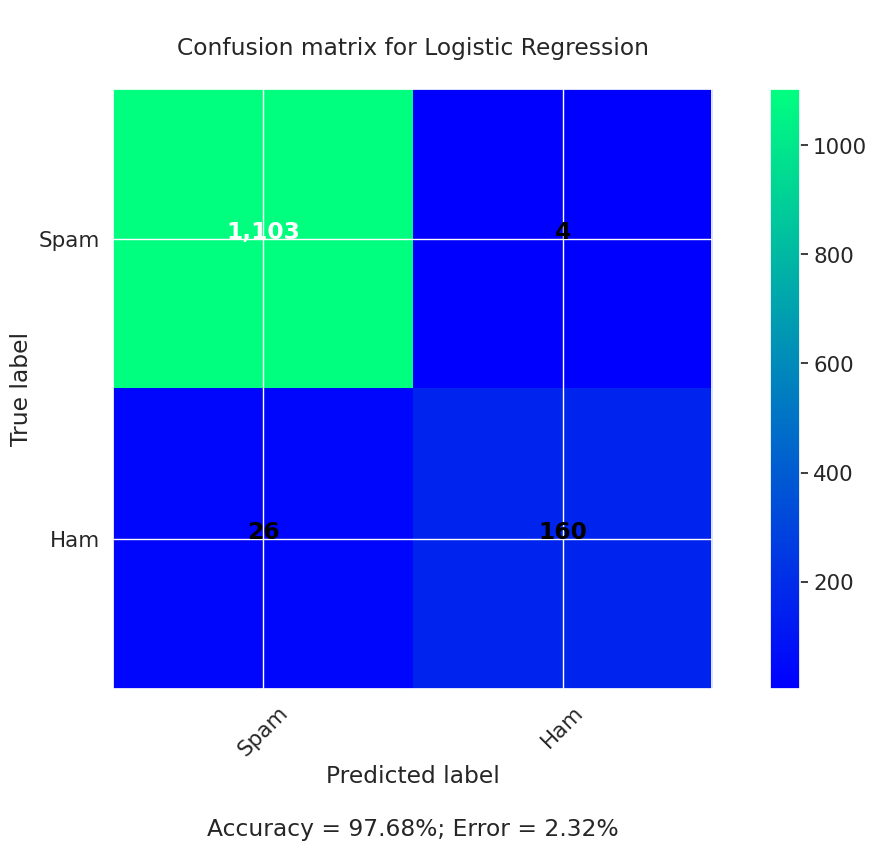

In [ ]:
print("\t\tStage IV. Logistic Regression\n")
class_LR = LogisticRegression(random_state = seed, solver = 'liblinear').fit(X_train, y_train)
y_pred_LR = class_LR.predict(X_test)
print('The first two predicted labels:', y_pred_LR[0], y_pred_LR[1], '\n')
conf_m_LR = confusion_matrix(y_test, y_pred_LR)
class_rep_LR = classification_report(y_test, y_pred_LR)
print('\t\t\tClassification report:\n\n', class_rep_LR, '\n')
plot_conf_matr(conf_m_LR, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for Logistic Regression')

In [ ]:
print("Stage I. Preliminary actions. Preparing of needed sets\n")

sentences_new_set = []
labels_new_set = []
for i in range(0, df_spam.shape[0], 1):
    sentences_new_set.append(df_spam['message'][i])
    labels_new_set.append(df_spam['feature'][i])

Stage I. Preliminary actions. Preparing of needed sets



In [ ]:
train_size = int(df_spam.shape[0] * (1 - test_size - valid_size))
valid_bound = int(df_spam.shape[0] * (1 - valid_size))

train_sentences = sentences_new_set[0 : train_size]
valid_sentences = sentences_new_set[train_size : valid_bound]
test_sentences = sentences_new_set[valid_bound : ]

train_labels_str = labels_new_set[0 : train_size]
valid_labels_str = labels_new_set[train_size : valid_bound]
test_labels_str = labels_new_set[valid_bound : ]

In [ ]:
print("Stage II. Labels transformations\n")

train_labels = [0] * len(train_labels_str)
for ind, item in enumerate(train_labels_str):
    if item == 'ham':
        train_labels[ind] = 1
    else:
        train_labels[ind] = 0

valid_labels = [0] * len(valid_labels_str)
for ind, item in enumerate(valid_labels_str):
    if item == 'ham':
        valid_labels[ind] = 1
    else:
        valid_labels[ind] = 0

test_labels = [0] * len(test_labels_str)
for ind, item in enumerate(test_labels_str):
    if item == 'ham':
        test_labels[ind] = 1
    else:
        test_labels[ind] = 0

train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)
test_labels = np.array(test_labels)

Stage II. Labels transformations



In [ ]:
print("Stage III. Tokenization\n")

tokenizer = Tokenizer(num_words = size_vocabulary,
                      oov_token = oov_token,
                      lower = False)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

Stage III. Tokenization



In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
size_voc = len(word_index) + 1
max_len = max([len(i) for i in train_sequences])
train_set = pad_sequences(train_sequences,
                                padding = padding_type,
                                maxlen = max_len,
                                truncating = trunc_type)

valid_sequences = tokenizer.texts_to_sequences(valid_sentences)
valid_set = pad_sequences(valid_sequences,
                               padding = padding_type,
                               maxlen = max_len,
                               truncating = trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_set = pad_sequences(test_sequences,
                               padding = padding_type,
                               maxlen = max_len,
                               truncating = trunc_type)

In [ ]:
print("Stage IV. Model building\n")

model = Sequential([
    Embedding(input_dim=size_voc, output_dim=embedding_dimension, input_shape=(max_len,)),
    Bidirectional(LSTM(100)),
    Dropout(drop_level),
    Dense(20, activation='relu'),
    Dropout(drop_level),
    Dense(1, activation='sigmoid')
])

Stage IV. Model building



In [ ]:
print("Stage V. Model compiling & fitting\n")

optim = Adam(learning_rate=0.0003)
model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])

model.summary()

Stage V. Model compiling & fitting



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 189, 64)        │       606,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200)            │       132,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │         4,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 742,121 (2.83 MB)

 Trainable params: 742,121 (2.83 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_set,
                    train_labels,
                    epochs = num_epochs,
                    validation_data = (valid_set, valid_labels),
                    verbose = 1)

Epoch 1/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 33s 236ms/step - accuracy: 0.8072 - loss: 0.5435 - val_accuracy: 0.9228 - val_loss: 0.2942
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 235ms/step - accuracy: 0.8854 - loss: 0.2547 - val_accuracy: 0.9344 - val_loss: 0.1771
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 29s 236ms/step - accuracy: 0.9625 - loss: 0.1276 - val_accuracy: 0.9691 - val_loss: 0.0910
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 232ms/step - accuracy: 0.9790 - loss: 0.0857 - val_accuracy: 0.9807 - val_loss: 0.0716
Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 233ms/step - accuracy: 0.9863 - loss: 0.0618 - val_accuracy: 0.9807 - val_loss: 0.0646
Epoch 6/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 234ms/step - accuracy: 0.9857 - loss: 0.0629 - val_accuracy: 0.9923 - val_loss: 0.0512
Epoch 7/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 232ms/step - accuracy: 0.9923 - loss: 0.0404 - val_accuracy: 0.9884 - val_loss: 0.0580
Epoch 8/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 231ms/step - accuracy: 0.9923 - loss: 0

In [ ]:
model_score = model.evaluate(test_set, test_labels, batch_size = embedding_dimension, verbose = 1)
print(f"Test accuracy: {model_score[1] * 100:0.2f}% \t\t Test error: {model_score[0]:0.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.9849 - loss: 0.0783
Test accuracy: 98.36% 		 Test error: 0.0771


In [ ]:
M_name = "My_model"
pickle.dump(tokenizer, open(M_name + ".pkl", "wb"))
filepath = M_name + '.h5'
tf.keras.models.save_model(model, filepath, include_optimizer = True, save_format = 'h5', overwrite = True)
print("Size of the saved model :", os.stat(filepath).st_size, "bytes")

Size of the saved model : 8956520 bytes


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step
			Classification report:

               precision    recall  f1-score   support

           0       0.92      0.94      0.93       117
           1       0.99      0.99      0.99       917

    accuracy                           0.98      1034
   macro avg       0.95      0.96      0.96      1034
weighted avg       0.98      0.98      0.98      1034
 



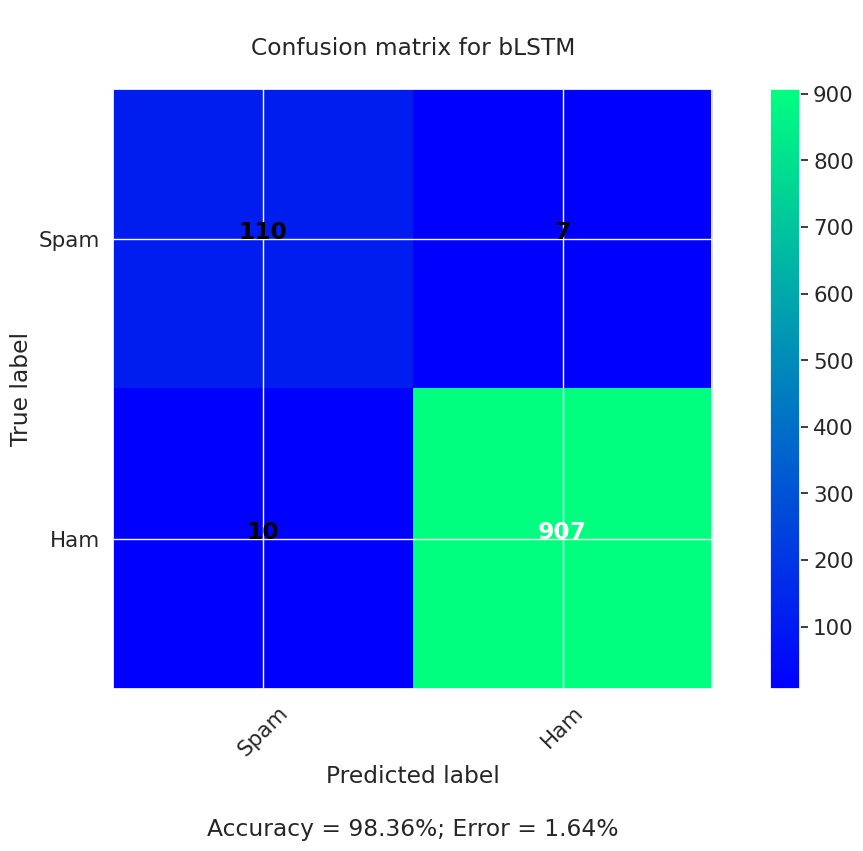

In [ ]:
y_pred_bLSTM = model.predict(test_set)

y_prediction = [0] * y_pred_bLSTM.shape[0]
for ind, item in enumerate(y_pred_bLSTM):
    if item > threshold:
        y_prediction[ind] = 1
    else:
        y_prediction[ind] = 0

conf_m_bLSTM = confusion_matrix(test_labels, y_prediction)
class_rep_bLSTM = classification_report(test_labels, y_prediction)
print('\t\t\tClassification report:\n\n', class_rep_bLSTM, '\n')
plot_conf_matr(conf_m_bLSTM, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for bLSTM')

In [ ]:
# You can change this message (as any short sentence) yourself
message_example = ["Darling, please give me a cup of tea"]

message_example_tp = pad_sequences(tokenizer.texts_to_sequences(message_example),
                                   maxlen = max_len,
                                   padding = padding_type,
                                   truncating = trunc_type)

pred = float(model.predict(message_example_tp))
if (pred > threshold):
    print ("This message is a real text")
else:
    print("This message is a spam message")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
This message is a real text


Stage VI. Results visualization



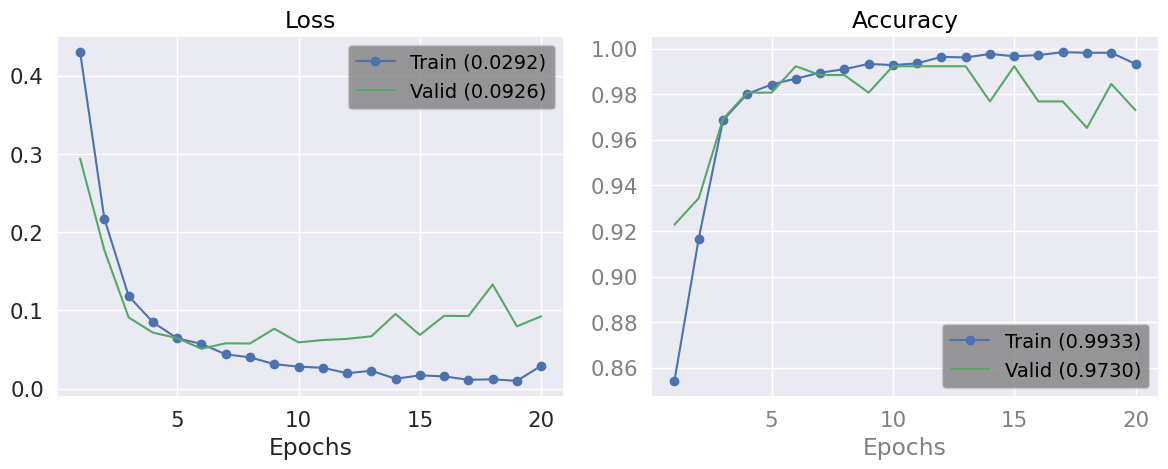

In [ ]:
print("Stage VI. Results visualization\n")
plot_history(history)